# Model-based attacks VS FGSM / iFGSM

## Preprocessing

In [18]:
# !pip install tsai
# !pip install optuna

In [19]:
SEED = 123
import random, os
import numpy as np
import torch

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tsai.models.all import ResCNN
import torch, torch.nn as nn, torch.nn.functional as F
from collections import defaultdict

In [16]:

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### EarlyStopping utility

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, mode='min'):
        assert mode in ('min', 'max')
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            self.counter = 0
            return False
        improvement = (metric < self.best - self.min_delta) if self.mode == 'min' else (metric > self.best + self.min_delta)
        if improvement:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop


### Dataset preparation

In [5]:
TRAIN_PATH = Path('PowerCons_TRAIN.tsv')
TEST_PATH = Path('PowerCons_TEST.tsv')
BATCH_SIZE = 64
# EPOCHS = 50
# LR = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def load_powercon(path: Path):
    df = pd.read_csv(path, sep='\t', header=None)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y).astype(np.int64)
    return X, y_encoded, le.classes_

In [7]:
X_train, y_train, classes_ = load_powercon(TRAIN_PATH)
X_test, y_test, _ = load_powercon(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [8]:
class PowerConDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PowerConDataset(X_train, y_train)
test_ds = PowerConDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [9]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


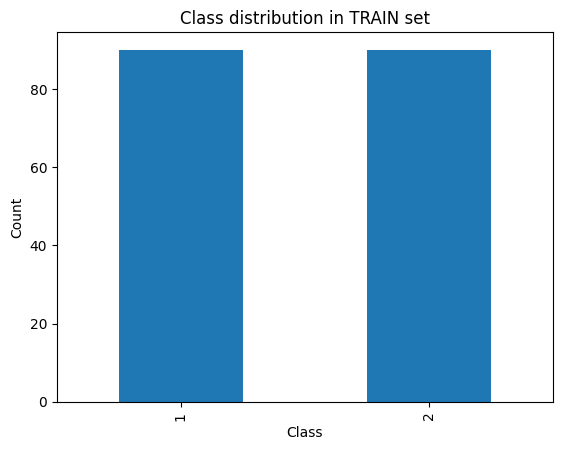

In [13]:
# check data-balance

df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

# 1. Считаем количество примеров каждого класса
label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')                # абсолютные значения
print(f'shares:\n{label_counts / len(df)}')      # доли

# 2. Быстрый бар-чарт
label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [14]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Classifiers

In [ ]:
def accuracy(logits, target):
    return (logits.argmax(1) == target).float().mean().item()

In [20]:
class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

### LSTM Classifier

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_classes, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
    def forward(self, x):
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

# model = LSTMClassifier(n_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# stopper_cls = EarlyStopping(patience=4, mode="min")
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     total_loss, correct = 0., 0
#     for xb, yb in train_dl:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = criterion(out, yb)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * xb.size(0)
#         correct += (out.argmax(1) == yb).sum().item()
#     train_acc = correct / len(train_ds)

#     model.eval()
#     val_loss, val_correct = 0., 0
#     with torch.no_grad():
#         for xb, yb in test_dl:
#             xb, yb = xb.to(device), yb.to(device)
#             out = model(xb)
#             val_loss += criterion(out, yb).item() * xb.size(0)
#             val_correct += (out.argmax(1) == yb).sum().item()
#     val_loss /= len(test_ds)
#     val_acc = val_correct / len(test_ds)
#     print(f'Epoch {epoch:2d} | train_acc {train_acc:.3f} | val_loss {val_loss:.4f} | val_acc {val_acc:.3f}')

#     if stopper_cls.step(val_loss):
#         print(f'⏹ Early stopping classifier at epoch {epoch}')
#         break


### ResCNN Classifier

In [21]:
class ResCNNClassifier(nn.Module):
    """
    Принимает тензор (B, L, C)  или (B, C, L).
    Возвращает logits размера (B, n_classes).
    """
    def __init__(self, n_classes, x_dim=1, activation_type='identity', rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}

        # тело сети: tsai.models.ResCNN
        self.body = ResCNN(c_in=x_dim, c_out=n_classes, **rescnn_kwargs)

        # финальная активация (чаще identity, а Softmax применяют в loss)
        self.fin = Activation(activation_type)

    def forward(self, x):
        # Допускаем форматы (B,L,C) и (B,C,L) — приводим к (B,C,L)
        if x.ndim == 3 and x.shape[1] != self.x_dim:   # значит (B,L,C)
            x = x.transpose(1, 2)
        return self.fin(self.body(x))                  # logits

### Training classifiers

In [22]:
def train_classifier(model,
                     train_loader,
                     val_loader=None,
                     epochs=50,
                     lr=1e-3,
                     weight_decay=0.,
                     device="cpu",
                     patience=5,
                     verbose_every=3):
    """
    returns: dict(history), best_val_loss, best_state_dict
    """
    model.to(device)
    opt      = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    stopper  = EarlyStopping(patience=patience, mode="min") if val_loader else None
    history  = defaultdict(list)
    best_wts = model.state_dict()
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        # ----- train -----
        model.train()
        loss_sum, acc_sum, n = 0., 0., 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss   = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item() * x.size(0)
            acc_sum  += (logits.argmax(1) == y).float().sum().item()
            n += x.size(0)

        train_loss = loss_sum / n
        train_acc  = acc_sum  / n
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----- validation -----
        if val_loader:
            model.eval()
            with torch.no_grad():
                loss_sum, acc_sum, n = 0., 0., 0
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss   = F.cross_entropy(logits, y)
                    loss_sum += loss.item() * x.size(0)
                    acc_sum  += (logits.argmax(1) == y).float().sum().item()
                    n += x.size(0)

            val_loss = loss_sum / n
            val_acc  = acc_sum  / n
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            if val_loss < best_val:
                best_val = val_loss
                best_wts = {k: v.cpu() for k, v in model.state_dict().items()}

            if stopper and stopper.step(val_loss):
                if verbose_every:
                    print(f"⏹ Early stopping on epoch {ep:02d}")
                break

        if verbose_every and ep % verbose_every == 0:
            msg = f"Epoch {ep:02d}: train_loss={train_loss:.4f} acc={train_acc:.4f}"
            if val_loader:
                msg += f" | val_loss={val_loss:.4f} acc={val_acc:.4f}"
            print(msg)

    model.load_state_dict(best_wts)
    return history, best_val, best_wts



#### train clf_LSTM

In [25]:
clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=50,
    lr=0.23,
    weight_decay=0.,
    device="cpu",
    patience=4,
    verbose_every=1
)

Epoch 01: train_loss=2.1568 acc=0.5167 | val_loss=2.4786 acc=0.4667
Epoch 02: train_loss=1.3770 acc=0.3889 | val_loss=0.8321 acc=0.5000
Epoch 03: train_loss=0.7586 acc=0.5222 | val_loss=0.7584 acc=0.5000
Epoch 04: train_loss=0.6891 acc=0.5889 | val_loss=0.7686 acc=0.5000
Epoch 05: train_loss=0.7034 acc=0.5556 | val_loss=0.9483 acc=0.5111
Epoch 06: train_loss=0.8131 acc=0.5333 | val_loss=0.8495 acc=0.5000
⏹ Early stopping on epoch 07


#### train clf_resCNN

In [27]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=20,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.4886 acc=0.7167 | val_loss=0.5218 acc=0.8500
Epoch 02: train_loss=0.3688 acc=0.8667 | val_loss=0.4559 acc=0.8000
Epoch 03: train_loss=0.3411 acc=0.8722 | val_loss=0.4276 acc=0.8167
Epoch 04: train_loss=0.3393 acc=0.8667 | val_loss=0.3966 acc=0.8333
Epoch 05: train_loss=0.3111 acc=0.8500 | val_loss=0.3979 acc=0.8333
Epoch 06: train_loss=0.2970 acc=0.8556 | val_loss=0.3416 acc=0.8556
Epoch 07: train_loss=0.2600 acc=0.8667 | val_loss=0.3875 acc=0.8111
Epoch 08: train_loss=0.2590 acc=0.9000 | val_loss=0.4418 acc=0.7611
Epoch 09: train_loss=0.2268 acc=0.9056 | val_loss=0.5121 acc=0.7111
Epoch 10: train_loss=0.2207 acc=0.9056 | val_loss=0.8298 acc=0.5056
Epoch 11: train_loss=0.2189 acc=0.9000 | val_loss=0.6948 acc=0.5611
Epoch 12: train_loss=0.1837 acc=0.9444 | val_loss=1.0160 acc=0.5000
Epoch 13: train_loss=0.1758 acc=0.9333 | val_loss=1.1703 acc=0.5000
Epoch 14: train_loss=0.1562 acc=0.9667 | val_loss=0.4157 acc=0.7500
Epoch 15: train_loss=0.1859 acc=0.9222 | val_los

In [20]:
# import optuna
# def objective(trial):
#     # --- гиперпараметры ---
#     eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
#     lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
#     alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
#     patience  = trial.suggest_int("patience", 3, 10)
#     #? --- инициализация surrogate ---
#     surrogate = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh')
#     val_loss, val_acc = train_surrogate(
#         surrogate, model, train_dl,
#         eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
#         device=device, patience=patience
#     )

#     return val_acc  # тогда study = optuna.create_study(directions=["min", "min"])

# # 2) создаём исследование
# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# # 3) запускаем
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("Лучшие параметры:", study.best_params)


## Model-based attacks

### Surrogate adversarial model (attack_LSTM)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

class attack_LSTM(nn.Module):
    def __init__(self, hidden_dim=64, x_dim=1, activation_type='identity'):
        super().__init__()
        # ! dropout 0.25 <- 0.4
        self.rnn_inp = nn.LSTM(x_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.25)
        self.act = Activation(activation_type)
        # ! delete fc
        self.rnn_out = nn.LSTM(hidden_dim, x_dim, num_layers=3, batch_first=True, dropout=0.25)
        # self.fc = nn.Linear(hidden_dim, x_dim)
    def forward(self, data):
        x, _ = self.rnn_inp(data)
        x = self.act(x)
        x, _ = self.rnn_out(x)
        return x


In [22]:
def accuracy_from_logits(logits, target):
    return (logits.argmax(1) == target).float().mean().item()

In [23]:
# import matplotlib.pyplot as plt
EPS = 0.23
def train_surrogate(surr, 
                    victim, 
                    loader, 
                    eps=EPS, 
                    epochs=50, 
                    lr=1e-4, 
                    alpha_l2=1e-3, 
                    device='cpu', 
                    patience=4,
                    is_clamped=False,
                    is_debugged=False
                    ):
    surr.to(device)
    victim.to(device).eval()
    opt = torch.optim.Adam(surr.parameters(), lr)
    stopper = EarlyStopping(patience=patience, mode="max")
    for ep in range(1, epochs+1):
        surr.train()
        run_vloss, run_acc, n = 0., 0., 0

        
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            delta = eps * torch.tanh(surr(x))
            if is_clamped:
                delta = torch.clamp(delta, -1, 1)

            # x_adv = torch.clamp(x + delta, -1, 1)
            
            x_adv = x + delta
            logits = victim(x_adv)

            vloss = F.cross_entropy(logits, y)
            acc = (logits.argmax(1) == y).float().mean().item()
            reg = alpha_l2 * (delta**2).mean()
            loss = -(vloss - reg)
            # loss = reg*vloss**-1
            if is_debugged:
                print(f'\nx={((x[0].detach().cpu()**2).mean())**0.5}')
                print(f'delta={((delta[0].detach().cpu()**2).mean())**0.5}')
                print(f'y={y.detach().cpu()[0]}|logits={logits.detach().cpu().argmax(1)[0]}')
                print(f'vloss = {vloss}| reg = {reg}')
        
                with torch.no_grad():               # нам не нужен grad для печати
                    # ----- (1) % от разрешённого eps -----
                    # perc_eps = (delta.abs().mean() / eps * 100).item()

                    # ----- (2) % L2-нормы входа -----
                    # L2 посчитаем по каждому объекту, затем усредним
                    l2_delta = torch.norm(delta.view(delta.size(0), -1), p=2, dim=1)
                    l2_x_adv = torch.norm(x_adv.view(x_adv.size(0), -1), p=2, dim=1) + 1e-8
                    l2_x     = torch.norm(x.view(x.size(0), -1),     p=2, dim=1) + 1e-8
                    perc_l2_x_adv  = (l2_delta / l2_x_adv * 100).mean().item()
                    perc_l2_x  = (l2_x_adv / l2_x * 100).mean().item()

                print(f'\nL2:Δ/x_adv: {perc_l2_x_adv:6.2f}%   x_adv/x: {perc_l2_x:6.2f}%')



                # # ! Vizualization
                # if ep % 10 == 0:  # Например, каждые 10 эпох
                #     plt.figure(figsize=(10, 5))
                #     x_cpu = x.cpu().detach().numpy()
                #     x_adv_cpu = x_adv.cpu().detach().numpy()
                #     plt.plot(x_cpu[0], label='Оригинал (x)', alpha=0.7)
                #     plt.plot(x_adv_cpu[0], label='Атакованный (x_adv)', alpha=0.7)
                #     plt.title(f'Эпоха {ep}: Сравнение оригинала и атакованного')
                #     plt.xlabel('Номер точки')
                #     plt.ylabel('Значение')
                #     plt.legend()
                #     plt.show()
    
            opt.zero_grad()
            loss.backward()
            opt.step()
            run_vloss += vloss.item()*x.size(0)
            run_acc += acc * x.size(0)
            n += x.size(0)



        # ! eps_curr = eps * ...
        # if abs(run_acc/n - 0.5) < 0.01:
        #     print('\n<---eps_curr = eps*0.7--->\n')
        #     eps = eps*0.9
        
        val_loss = run_vloss / n
        print(f'\nEpoch {ep:02d} | victim‑loss {val_loss:.4f} | acc {run_acc/n:.4f}')
        if stopper.step(val_loss):
            print(f'⏹ Early stopping at epoch {ep}')
            break
    torch.save(surr.state_dict(), 'surrogate_maxloss.pth')
    return val_loss, run_acc/n


In [ ]:
surrogate_LSTM = attack_LSTM(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)
for p in model.parameters():
    p.requires_grad_(False)
model.eval()
# ! EPS, lr, EPOCHS
train_surrogate(surrogate_LSTM, 
                model, 
                train_dl, 
                eps=0.5, 
                epochs=45, 
                lr=1e-3, 
                alpha_l2=1e-2, 
                device=device, 
                patience=7
)


### Optuna(LSTM Attack)

In [31]:
# import optuna, torch, torch.nn.functional as F
# from functools import partial

# # 1) objective
# def objective(trial):
#     # --- гиперпараметры ---
#     eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
#     lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
#     alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
#     patience  = trial.suggest_int("patience", 3, 10)

#     # --- инициализация surrogate ---
#     surrogate = attack_LSTM(hidden_dim=64, x_dim=1, activation_type='tanh')
#     # можно фиксировать seed, чтобы уменьшить шум
#     # torch.manual_seed(0)

#     # --- обучение ---
#     val_loss, val_acc = train_surrogate(
#         surrogate, model, train_dl,
#         eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
#         device=device, patience=patience
#     )

#     # # 2-варианта цели
#     # # а) агрегированная: минимизируем loss + k * acc
#     # score = val_loss + 2.0 * val_acc   # k = 2 задаёт приоритет «валят-ли ?»
#     # return score          # Optuna МИНИМИЗИРУЕТ

#     # б) строго multi-objective:
#     return val_acc  # тогда study = optuna.create_study(directions=["min", "min"])


/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# # 2) создаём исследование
# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# # 3) запускаем
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("Лучшие параметры:", study.best_params)


### Fooling rate

In [25]:
import torch
import torch.nn.functional as F

def preds_to_labels(logits: torch.Tensor) -> torch.Tensor:
    return logits.argmax(dim=1)

def fooling_rate(model, loader, attack, device='cpu'):
    model.eval()
    fooled, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds_orig = preds_to_labels(model(x))
    fooled, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds_orig = preds_to_labels(model(x).detach())
        x_adv = attack(model, x, y)
        preds_adv = preds_to_labels(model(x_adv).detach())
        fooled += (preds_adv != preds_orig).sum().item()
        total += x.size(0)
    return fooled / total

### FGSM / iFGSM

In [26]:
class Attack:
    def __init__(self, eps: float, clamp=(-1, 1)):
        self.eps = eps
        self.clamp = clamp

class FGSMAttack(Attack):
    def __call__(self, model, x, y):
        x_req = x.clone().detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_req), y)
        loss.backward()
        delta = self.eps * x_req.grad.sign()
        x_adv = torch.clamp(x + delta, *self.clamp)
        return x_adv.detach()

class iFGSMAttack(Attack):
    def __init__(self, eps, n_iter=10, alpha=None, clamp=(-1, 1), rand_init=True):
        super().__init__(eps, clamp)
        self.n_iter = n_iter
        self.alpha = alpha if alpha is not None else 1.25 * eps / n_iter
        self.rand_init = rand_init

    def _clip(self, x_adv, x_orig):
        delta = torch.clamp(x_adv - x_orig, min=-self.eps, max=self.eps)
        return torch.clamp(x_orig + delta, *self.clamp)

    def __call__(self, model, x, y):
        model.eval()
        if self.rand_init:
            x_adv = x + torch.empty_like(x).uniform_(-self.eps, self.eps)
            x_adv = self._clip(x_adv, x).detach()
        else:
            x_adv = x.clone().detach()

        for _ in range(self.n_iter):
            x_adv.requires_grad_(True)
            loss = F.cross_entropy(model(x_adv), y)
            model.zero_grad()
            loss.backward()
            grad_sign = x_adv.grad.sign()
            x_adv = x_adv + self.alpha * grad_sign
            x_adv = self._clip(x_adv, x).detach()
        return x_adv

class ModelBasedAttack(Attack):
    def __init__(self, surrogate, eps, clamp=(-1, 1)):
        super().__init__(eps, clamp)
        self.surr = surrogate.eval()

    @torch.no_grad()
    def __call__(self, model, x, y):
        delta = self.eps * torch.tanh(self.surr(x))
        return torch.clamp(x + delta, *self.clamp)

In [27]:
fgsm_attack = FGSMAttack(EPS)
ifgsm_attack = iFGSMAttack(eps=0.26, alpha=0.1, n_iter=70)
model_attack_lstm = ModelBasedAttack(surrogate_LSTM, EPS)

### Surrogate adversarial model (attack_resCNN)

In [28]:
from tsai.models.all import ResCNN
import inspect

class ResCNNModel(nn.Module):
    def __init__(self, x_dim=1, output_dim=n_classes,
                 activation_type='identity',
                 rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}
        self.body = ResCNN(c_in=x_dim, c_out=output_dim, **rescnn_kwargs)
        self.fin = Activation(activation_type)
    def forward(self, x):
        if x.ndim == 3 and x.shape[1] != self.x_dim:
            x = x.transpose(1, 2)
        return self.fin(self.body(x))

In [42]:
class AttackCNN(nn.Module):
    def __init__(self, hidden_dim=128, x_dim=1, activation_type='tanh'):
        super().__init__()
        self.step_cnn = ResCNNModel(x_dim=x_dim, output_dim=hidden_dim, activation_type='identity')
        self.fc = nn.Linear(hidden_dim, x_dim)
        self.act = Activation(activation_type)
    def forward(self, x):
        B, L, C = x.shape
        x_flat = x.contiguous().view(B * L, 1, C)
        h = self.step_cnn(x_flat)
        h = h.view(B, L, -1)
        return self.fc(self.act(h))
        # return self.act(h)



In [ ]:
surrogate_cnn = AttackCNN().to(device)
surrogate_cnn = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

weights_path = 'log/surr_resCNNfc_CPU_0.28.pth'
surrogate_cnn.load_state_dict(torch.load(weights_path, map_location=device))


train_surrogate(surrogate_cnn, clf_resCNN, train_dl,
                eps=1.9910549963365909, 
                epochs=50, lr=0.0021041627898080928, alpha_l2=.549583575912758e-05, 
                device=device, patience=10, is_debugged=True)

model_attack_cnn = ModelBasedAttack(surrogate_cnn, eps=EPS)

### PatchTST Attack model

In [96]:

loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)           # длина последовательности
print("Sequence length =", seq_len)


Sequence length = 144


In [97]:
from typing import Optional              # иначе импортируйте из того места, где он объявлен

import torch
import tsai.models.all as mdls

from abc import abstractmethod

import torch


class BaseModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.self_supervised = False

class PatchTST(BaseModel):
    def __init__(self, activation_type: str = "sigmoid", **kwargs) -> None:
        super().__init__()
        self.model = mdls.PatchTST(**kwargs).float()
        self.final_activation = Activation(activation_type)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.transpose(1, 2)
        output = self.model(X)
        return self.final_activation(output).squeeze(-1)


class AttackPatchTST(nn.Module):
    """
    Атакующая модель, совместимая с train_surrogate.
    Из PatchTST берём глобальный эмбеддинг и проецируем его
    обратно в (B, L, C).
    """
    def __init__(
        self,
        hidden_dim: int = 128,
        x_dim: int = 1,
        activation_type: str = "tanh",
        patch_kwargs: Optional[dict] = None,
    ):
        super().__init__()

        patch_kwargs = patch_kwargs or {}
        # гарантируем нужный выход PatchTST
        patch_kwargs.update(dict(c_in=x_dim,
                                 c_out=hidden_dim,
                                 pred_dim=hidden_dim))

        self.step_model = PatchTST(activation_type="identity", **patch_kwargs)
        self.fc        = nn.Linear(hidden_dim, x_dim)
        self.act       = Activation(activation_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        h = self.step_model(x)          # (B, 1, 1, hidden_dim)

        h = h.view(B, -1)               # ← добавьте ЭТУ строку
        # либо h = h.squeeze(1).squeeze(1)

        h = h.unsqueeze(1).expand(-1, L, -1)   # (B, L, hidden_dim)
        return self.fc(self.act(h))            # (B, L, C)


In [108]:
patch_params = dict(
    seq_len=144,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=28,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

surr_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
)


train_surrogate(surr_PatchTST, clf_resCNN, train_dl,
                eps=1.52738926, 
                epochs=50, lr=0.000202314, alpha_l2=0.000114732, 
                device=device, patience=8, is_debugged=True)


x=0.8716756105422974
delta=0.3535308241844177
y=0|logits=1
vloss = 0.6379432082176208| reg = 3.509164889692329e-05

L2:Δ/x_adv:  37.73%   x_adv/x: 134.51%

x=1.3741307258605957
delta=0.45774170756340027
y=1|logits=1
vloss = 1.3229668140411377| reg = 5.540947677218355e-05

L2:Δ/x_adv:  48.89%   x_adv/x: 137.29%

x=0.8054031729698181
delta=1.4671612977981567
y=1|logits=0
vloss = 2.564018487930298| reg = 0.00010935177851933986

L2:Δ/x_adv:  63.70%   x_adv/x: 152.90%

Epoch 01 | victim‑loss 1.4379 | acc 0.7333

x=0.6089347004890442
delta=1.4368715286254883
y=0|logits=1
vloss = 2.794368267059326| reg = 0.000142697332194075

L2:Δ/x_adv:  65.47%   x_adv/x: 170.56%

x=0.7947620153427124
delta=0.24473334848880768
y=1|logits=1
vloss = 3.8283531665802| reg = 0.00017083885904867202

L2:Δ/x_adv:  76.41%   x_adv/x: 163.94%

x=0.7708216905593872
delta=1.1760693788528442
y=1|logits=0
vloss = 3.9711990356445312| reg = 0.00016468102694489062

L2:Δ/x_adv:  79.04%   x_adv/x: 164.36%

Epoch 02 | victim‑lo

(6.744794654846191, 0.05555555638339785)

#### optuna(resCNN)

In [135]:
import optuna, torch, torch.nn.functional as F
from functools import partial

# 1) objective
def objective(trial):
    # --- гиперпараметры ---
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)

    #? --- инициализация surrogate ---
    surrogate = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh')
    # можно фиксировать seed, чтобы уменьшить шум
    # torch.manual_seed(0)

    # --- обучение ---
    val_loss, val_acc = train_surrogate(
        surrogate, model, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc  # тогда study = optuna.create_study(directions=["min", "min"])

# 2) создаём исследование
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# 3) запускаем
study.optimize(objective, n_trials=50, timeout=60*60)
print("Лучшие параметры:", study.best_params)


[I 2025-08-02 21:33:09,457] A new study created in memory with name: no-name-4dd4ba95-6c62-4781-83ad-423f32840276



Epoch 01 | victim‑loss 0.4377 | acc 0.8389

Epoch 02 | victim‑loss 0.6928 | acc 0.7778

Epoch 03 | victim‑loss 0.7217 | acc 0.7667

Epoch 04 | victim‑loss 0.7484 | acc 0.7556

Epoch 05 | victim‑loss 0.7618 | acc 0.7500

Epoch 06 | victim‑loss 0.7671 | acc 0.7500

Epoch 07 | victim‑loss 0.7751 | acc 0.7444

Epoch 08 | victim‑loss 0.7769 | acc 0.7389

Epoch 09 | victim‑loss 0.7800 | acc 0.7333

Epoch 10 | victim‑loss 0.7822 | acc 0.7333

Epoch 11 | victim‑loss 0.7836 | acc 0.7333

Epoch 12 | victim‑loss 0.7855 | acc 0.7333

Epoch 13 | victim‑loss 0.7879 | acc 0.7333

Epoch 14 | victim‑loss 0.7878 | acc 0.7333

Epoch 15 | victim‑loss 0.7876 | acc 0.7333

Epoch 16 | victim‑loss 0.7890 | acc 0.7333

Epoch 17 | victim‑loss 0.7904 | acc 0.7333

Epoch 18 | victim‑loss 0.7891 | acc 0.7333

Epoch 19 | victim‑loss 0.7912 | acc 0.7333

Epoch 20 | victim‑loss 0.7915 | acc 0.7333

Epoch 21 | victim‑loss 0.7915 | acc 0.7333

Epoch 22 | victim‑loss 0.7919 | acc 0.7333

Epoch 23 | victim‑loss 0.7921 |

[I 2025-08-02 21:35:44,163] Trial 0 finished with value: 0.733333330684238 and parameters: {'eps': 0.7392812671007061, 'lr': 0.0016936381140737328, 'alpha_l2': 0.022579812824037215, 'patience': 4}. Best is trial 0 with value: 0.733333330684238.



Epoch 49 | victim‑loss 0.7948 | acc 0.7333
⏹ Early stopping at epoch 49

Epoch 01 | victim‑loss 0.3476 | acc 0.8444

Epoch 02 | victim‑loss 0.8209 | acc 0.6944

Epoch 03 | victim‑loss 0.9484 | acc 0.6556

Epoch 04 | victim‑loss 0.9799 | acc 0.6500

Epoch 05 | victim‑loss 0.9887 | acc 0.6500

Epoch 06 | victim‑loss 0.9999 | acc 0.6389

Epoch 07 | victim‑loss 0.9977 | acc 0.6444

Epoch 08 | victim‑loss 1.0021 | acc 0.6389

Epoch 09 | victim‑loss 1.0114 | acc 0.6389

Epoch 10 | victim‑loss 1.0167 | acc 0.6389

Epoch 11 | victim‑loss 1.0164 | acc 0.6389

Epoch 12 | victim‑loss 1.0264 | acc 0.6389

Epoch 13 | victim‑loss 1.0292 | acc 0.6389

Epoch 14 | victim‑loss 1.0316 | acc 0.6389

Epoch 15 | victim‑loss 1.0331 | acc 0.6389

Epoch 16 | victim‑loss 1.0351 | acc 0.6389

Epoch 17 | victim‑loss 1.0369 | acc 0.6389

Epoch 18 | victim‑loss 1.0375 | acc 0.6389

Epoch 19 | victim‑loss 1.0374 | acc 0.6389

Epoch 20 | victim‑loss 1.0381 | acc 0.6389

Epoch 21 | victim‑loss 1.0380 | acc 0.6389

Ep

[I 2025-08-02 21:37:21,135] Trial 1 finished with value: 0.6388888902134365 and parameters: {'eps': 1.20110253937726, 'lr': 0.003180459634751617, 'alpha_l2': 5.3988033809533114e-05, 'patience': 5}. Best is trial 1 with value: 0.6388888902134365.



Epoch 31 | victim‑loss 1.0389 | acc 0.6389
⏹ Early stopping at epoch 31

Epoch 01 | victim‑loss 0.3831 | acc 0.8500

Epoch 02 | victim‑loss 0.7275 | acc 0.7278

Epoch 03 | victim‑loss 0.9272 | acc 0.6556

Epoch 04 | victim‑loss 1.0332 | acc 0.6111

Epoch 05 | victim‑loss 1.0510 | acc 0.6056

Epoch 06 | victim‑loss 1.0515 | acc 0.6056

Epoch 07 | victim‑loss 1.0777 | acc 0.6000

Epoch 08 | victim‑loss 1.0886 | acc 0.6000

Epoch 09 | victim‑loss 1.0951 | acc 0.6000

Epoch 10 | victim‑loss 1.1024 | acc 0.5944

Epoch 11 | victim‑loss 1.1054 | acc 0.5889

Epoch 12 | victim‑loss 1.1078 | acc 0.5889

Epoch 13 | victim‑loss 1.1095 | acc 0.5889

Epoch 14 | victim‑loss 1.1111 | acc 0.5889

Epoch 15 | victim‑loss 1.1134 | acc 0.5889

Epoch 16 | victim‑loss 1.1152 | acc 0.5889

Epoch 17 | victim‑loss 1.1164 | acc 0.5889

Epoch 18 | victim‑loss 1.1145 | acc 0.5889

Epoch 19 | victim‑loss 1.1207 | acc 0.5889

Epoch 20 | victim‑loss 1.1226 | acc 0.5889

Epoch 21 | victim‑loss 1.1240 | acc 0.5889

Ep

[I 2025-08-02 21:38:51,370] Trial 2 finished with value: 0.5888888875643412 and parameters: {'eps': 1.3741736528516024, 'lr': 0.0010039959739294752, 'alpha_l2': 0.0001719827494036618, 'patience': 3}. Best is trial 2 with value: 0.5888888875643412.



Epoch 30 | victim‑loss 1.1266 | acc 0.5889
⏹ Early stopping at epoch 30

Epoch 01 | victim‑loss 0.3396 | acc 0.8833

Epoch 02 | victim‑loss 0.7489 | acc 0.7611

Epoch 03 | victim‑loss 0.7753 | acc 0.7444

Epoch 04 | victim‑loss 0.7801 | acc 0.7444

Epoch 05 | victim‑loss 0.7805 | acc 0.7444

Epoch 06 | victim‑loss 0.7807 | acc 0.7444

Epoch 07 | victim‑loss 0.7807 | acc 0.7444

Epoch 08 | victim‑loss 0.7808 | acc 0.7444

Epoch 09 | victim‑loss 0.7808 | acc 0.7444

Epoch 10 | victim‑loss 0.7808 | acc 0.7444

Epoch 11 | victim‑loss 0.7808 | acc 0.7444

Epoch 12 | victim‑loss 0.7808 | acc 0.7444


[I 2025-08-02 21:39:29,976] Trial 3 finished with value: 0.7444444364971585 and parameters: {'eps': 0.7255583330284175, 'lr': 0.009969808388371462, 'alpha_l2': 0.0010662707943645557, 'patience': 5}. Best is trial 2 with value: 0.5888888875643412.



Epoch 13 | victim‑loss 0.7809 | acc 0.7444
⏹ Early stopping at epoch 13

Epoch 01 | victim‑loss 0.2277 | acc 0.9000

Epoch 02 | victim‑loss 0.2687 | acc 0.8667

Epoch 03 | victim‑loss 0.3207 | acc 0.8722

Epoch 04 | victim‑loss 0.3773 | acc 0.8556

Epoch 05 | victim‑loss 0.5059 | acc 0.8278

Epoch 06 | victim‑loss 0.5696 | acc 0.8111

Epoch 07 | victim‑loss 0.5771 | acc 0.8056

Epoch 08 | victim‑loss 0.5782 | acc 0.8056

Epoch 09 | victim‑loss 0.5786 | acc 0.8056

Epoch 10 | victim‑loss 0.5789 | acc 0.8056

Epoch 11 | victim‑loss 0.5792 | acc 0.8056

Epoch 12 | victim‑loss 0.5793 | acc 0.8056

Epoch 13 | victim‑loss 0.5794 | acc 0.8056

Epoch 14 | victim‑loss 0.5795 | acc 0.8056

Epoch 15 | victim‑loss 0.5795 | acc 0.8056

Epoch 16 | victim‑loss 0.5796 | acc 0.8056

Epoch 17 | victim‑loss 0.5796 | acc 0.8056

Epoch 18 | victim‑loss 0.5796 | acc 0.8056


[I 2025-08-02 21:40:21,988] Trial 4 finished with value: 0.8055555621782938 and parameters: {'eps': 0.5462662177107335, 'lr': 0.008315865356982876, 'alpha_l2': 9.947039228484918e-05, 'patience': 3}. Best is trial 2 with value: 0.5888888875643412.



Epoch 19 | victim‑loss 0.5796 | acc 0.8056
⏹ Early stopping at epoch 19

Epoch 01 | victim‑loss 0.4293 | acc 0.8000

Epoch 02 | victim‑loss 0.5484 | acc 0.7833

Epoch 03 | victim‑loss 0.5842 | acc 0.7611

Epoch 04 | victim‑loss 0.5878 | acc 0.7667

Epoch 05 | victim‑loss 0.6006 | acc 0.7667

Epoch 06 | victim‑loss 0.6124 | acc 0.7611

Epoch 07 | victim‑loss 0.6172 | acc 0.7500

Epoch 08 | victim‑loss 0.6279 | acc 0.7444

Epoch 09 | victim‑loss 0.6292 | acc 0.7444

Epoch 10 | victim‑loss 0.6307 | acc 0.7444

Epoch 11 | victim‑loss 0.6319 | acc 0.7444

Epoch 12 | victim‑loss 0.6325 | acc 0.7444

Epoch 13 | victim‑loss 0.6329 | acc 0.7444

Epoch 14 | victim‑loss 0.6331 | acc 0.7444

Epoch 15 | victim‑loss 0.6332 | acc 0.7444

Epoch 16 | victim‑loss 0.6333 | acc 0.7444

Epoch 17 | victim‑loss 0.6334 | acc 0.7444

Epoch 18 | victim‑loss 0.6334 | acc 0.7444

Epoch 19 | victim‑loss 0.6334 | acc 0.7444

Epoch 20 | victim‑loss 0.6335 | acc 0.7444

Epoch 21 | victim‑loss 0.6335 | acc 0.7444

Ep

[I 2025-08-02 21:41:42,537] Trial 5 finished with value: 0.7444444404708015 and parameters: {'eps': 0.6370669484838568, 'lr': 0.004261062671251934, 'alpha_l2': 0.0003516150331645108, 'patience': 7}. Best is trial 2 with value: 0.5888888875643412.



Epoch 29 | victim‑loss 0.6335 | acc 0.7444
⏹ Early stopping at epoch 29

Epoch 01 | victim‑loss 0.3412 | acc 0.8667

Epoch 02 | victim‑loss 0.6308 | acc 0.7944

Epoch 03 | victim‑loss 0.7365 | acc 0.7611

Epoch 04 | victim‑loss 0.7537 | acc 0.7611

Epoch 05 | victim‑loss 0.7584 | acc 0.7611

Epoch 06 | victim‑loss 0.7596 | acc 0.7611

Epoch 07 | victim‑loss 0.7601 | acc 0.7611

Epoch 08 | victim‑loss 0.7604 | acc 0.7611

Epoch 09 | victim‑loss 0.7606 | acc 0.7611

Epoch 10 | victim‑loss 0.7607 | acc 0.7611

Epoch 11 | victim‑loss 0.7608 | acc 0.7611

Epoch 12 | victim‑loss 0.7608 | acc 0.7611

Epoch 13 | victim‑loss 0.7609 | acc 0.7611

Epoch 14 | victim‑loss 0.7609 | acc 0.7611

Epoch 15 | victim‑loss 0.7609 | acc 0.7611

Epoch 16 | victim‑loss 0.7609 | acc 0.7611

Epoch 17 | victim‑loss 0.7609 | acc 0.7611

Epoch 18 | victim‑loss 0.7609 | acc 0.7611

Epoch 19 | victim‑loss 0.7610 | acc 0.7611

Epoch 20 | victim‑loss 0.7610 | acc 0.7611

Epoch 21 | victim‑loss 0.7610 | acc 0.7611

Ep

[I 2025-08-02 21:42:53,454] Trial 6 finished with value: 0.7611111058129205 and parameters: {'eps': 0.7084626461137344, 'lr': 0.006015535679601945, 'alpha_l2': 1.3192446455857694e-05, 'patience': 7}. Best is trial 2 with value: 0.5888888875643412.



Epoch 24 | victim‑loss 0.7610 | acc 0.7611
⏹ Early stopping at epoch 24

Epoch 01 | victim‑loss 0.8516 | acc 0.6833

Epoch 02 | victim‑loss 0.9690 | acc 0.6556

Epoch 03 | victim‑loss 0.9903 | acc 0.6444

Epoch 04 | victim‑loss 0.9987 | acc 0.6444

Epoch 05 | victim‑loss 1.0073 | acc 0.6444

Epoch 06 | victim‑loss 1.0143 | acc 0.6444

Epoch 07 | victim‑loss 1.0167 | acc 0.6389

Epoch 08 | victim‑loss 1.0202 | acc 0.6389

Epoch 09 | victim‑loss 1.0219 | acc 0.6444

Epoch 10 | victim‑loss 1.0241 | acc 0.6389

Epoch 11 | victim‑loss 1.0184 | acc 0.6389

Epoch 12 | victim‑loss 1.0228 | acc 0.6444

Epoch 13 | victim‑loss 1.0269 | acc 0.6389

Epoch 14 | victim‑loss 1.0291 | acc 0.6389

Epoch 15 | victim‑loss 1.0297 | acc 0.6389

Epoch 16 | victim‑loss 1.0256 | acc 0.6389

Epoch 17 | victim‑loss 1.0269 | acc 0.6389

Epoch 18 | victim‑loss 1.0271 | acc 0.6389


[I 2025-08-02 21:43:53,844] Trial 7 finished with value: 0.6388888888888888 and parameters: {'eps': 1.208014504854384, 'lr': 0.0010090985286111006, 'alpha_l2': 0.09905616974759883, 'patience': 4}. Best is trial 2 with value: 0.5888888875643412.



Epoch 19 | victim‑loss 1.0286 | acc 0.6389
⏹ Early stopping at epoch 19

Epoch 01 | victim‑loss 0.2797 | acc 0.8778

Epoch 02 | victim‑loss 0.4245 | acc 0.8000

Epoch 03 | victim‑loss 0.4844 | acc 0.7944

Epoch 04 | victim‑loss 0.5219 | acc 0.7889

Epoch 05 | victim‑loss 0.5544 | acc 0.7722

Epoch 06 | victim‑loss 0.5620 | acc 0.7778

Epoch 07 | victim‑loss 0.5738 | acc 0.7722

Epoch 08 | victim‑loss 0.5786 | acc 0.7722

Epoch 09 | victim‑loss 0.5835 | acc 0.7722

Epoch 10 | victim‑loss 0.5878 | acc 0.7611

Epoch 11 | victim‑loss 0.5891 | acc 0.7611

Epoch 12 | victim‑loss 0.5927 | acc 0.7611

Epoch 13 | victim‑loss 0.5951 | acc 0.7611

Epoch 14 | victim‑loss 0.5967 | acc 0.7556

Epoch 15 | victim‑loss 0.5960 | acc 0.7556

Epoch 16 | victim‑loss 0.5973 | acc 0.7611

Epoch 17 | victim‑loss 0.5987 | acc 0.7611

Epoch 18 | victim‑loss 0.5993 | acc 0.7611

Epoch 19 | victim‑loss 0.6005 | acc 0.7556

Epoch 20 | victim‑loss 0.6015 | acc 0.7556

Epoch 21 | victim‑loss 0.6015 | acc 0.7556

Ep

[I 2025-08-02 21:46:36,912] Trial 8 finished with value: 0.7555555608537462 and parameters: {'eps': 0.6194593862550727, 'lr': 0.0010706338836605571, 'alpha_l2': 0.01630681030825733, 'patience': 7}. Best is trial 2 with value: 0.5888888875643412.



Epoch 50 | victim‑loss 0.6055 | acc 0.7556

Epoch 01 | victim‑loss 0.3220 | acc 0.8833

Epoch 02 | victim‑loss 0.9250 | acc 0.6444

Epoch 03 | victim‑loss 1.4384 | acc 0.5278

Epoch 04 | victim‑loss 1.6863 | acc 0.5000

Epoch 05 | victim‑loss 1.7212 | acc 0.5000

Epoch 06 | victim‑loss 1.7282 | acc 0.5000

Epoch 07 | victim‑loss 1.7322 | acc 0.5000

Epoch 08 | victim‑loss 1.7374 | acc 0.5000

Epoch 09 | victim‑loss 1.7406 | acc 0.5000

Epoch 10 | victim‑loss 1.7431 | acc 0.5000

Epoch 11 | victim‑loss 1.7450 | acc 0.5000

Epoch 12 | victim‑loss 1.7450 | acc 0.5000

Epoch 13 | victim‑loss 1.7473 | acc 0.5000

Epoch 14 | victim‑loss 1.7483 | acc 0.5000

Epoch 15 | victim‑loss 1.7490 | acc 0.5000

Epoch 16 | victim‑loss 1.7500 | acc 0.5000

Epoch 17 | victim‑loss 1.7495 | acc 0.5000

Epoch 18 | victim‑loss 1.7513 | acc 0.5000

Epoch 19 | victim‑loss 1.7518 | acc 0.5000

Epoch 20 | victim‑loss 1.7522 | acc 0.5000

Epoch 21 | victim‑loss 1.7524 | acc 0.5000

Epoch 22 | victim‑loss 1.7535 |

[I 2025-08-02 21:49:01,165] Trial 9 finished with value: 0.5 and parameters: {'eps': 1.4016698892643262, 'lr': 0.001169599373901301, 'alpha_l2': 0.01499116437719921, 'patience': 8}. Best is trial 9 with value: 0.5.



Epoch 50 | victim‑loss 1.7589 | acc 0.5000

Epoch 01 | victim‑loss 0.8986 | acc 0.6444

Epoch 02 | victim‑loss 1.6601 | acc 0.3111

Epoch 03 | victim‑loss 1.8800 | acc 0.2278

Epoch 04 | victim‑loss 1.9496 | acc 0.2500

Epoch 05 | victim‑loss 1.9418 | acc 0.2556

Epoch 06 | victim‑loss 1.9470 | acc 0.2167

Epoch 07 | victim‑loss 1.8815 | acc 0.2889

Epoch 08 | victim‑loss 1.8275 | acc 0.3333

Epoch 09 | victim‑loss 1.9306 | acc 0.3000

Epoch 10 | victim‑loss 1.9314 | acc 0.2611

Epoch 11 | victim‑loss 1.9956 | acc 0.2167

Epoch 12 | victim‑loss 1.9758 | acc 0.2167

Epoch 13 | victim‑loss 1.9558 | acc 0.2389

Epoch 14 | victim‑loss 1.9691 | acc 0.2056

Epoch 15 | victim‑loss 1.9656 | acc 0.2389

Epoch 16 | victim‑loss 1.9821 | acc 0.2556

Epoch 17 | victim‑loss 1.9581 | acc 0.2167

Epoch 18 | victim‑loss 1.9759 | acc 0.2278

Epoch 19 | victim‑loss 1.9313 | acc 0.2667


[I 2025-08-02 21:49:59,365] Trial 10 finished with value: 0.23333333399560716 and parameters: {'eps': 1.6933718164619331, 'lr': 0.0019538334269248044, 'alpha_l2': 0.002840623846835587, 'patience': 9}. Best is trial 10 with value: 0.23333333399560716.



Epoch 20 | victim‑loss 1.9566 | acc 0.2333
⏹ Early stopping at epoch 20

Epoch 01 | victim‑loss 1.6257 | acc 0.4056

Epoch 02 | victim‑loss 2.2056 | acc 0.1722

Epoch 03 | victim‑loss 2.2192 | acc 0.1667

Epoch 04 | victim‑loss 2.3018 | acc 0.1444

Epoch 05 | victim‑loss 2.2243 | acc 0.2000

Epoch 06 | victim‑loss 2.2466 | acc 0.1667

Epoch 07 | victim‑loss 2.2730 | acc 0.1444

Epoch 08 | victim‑loss 2.3229 | acc 0.1333

Epoch 09 | victim‑loss 2.2990 | acc 0.1611

Epoch 10 | victim‑loss 2.1764 | acc 0.2056

Epoch 11 | victim‑loss 2.3024 | acc 0.1556

Epoch 12 | victim‑loss 2.2757 | acc 0.1444

Epoch 13 | victim‑loss 2.2573 | acc 0.1778

Epoch 14 | victim‑loss 2.2707 | acc 0.1389

Epoch 15 | victim‑loss 2.2851 | acc 0.1333

Epoch 16 | victim‑loss 2.3348 | acc 0.1167

Epoch 17 | victim‑loss 2.2284 | acc 0.2000

Epoch 18 | victim‑loss 2.2316 | acc 0.1833

Epoch 19 | victim‑loss 2.2941 | acc 0.1444

Epoch 20 | victim‑loss 2.3049 | acc 0.1500

Epoch 21 | victim‑loss 2.2490 | acc 0.1722

Ep

[I 2025-08-02 21:51:20,695] Trial 11 finished with value: 0.1611111130979326 and parameters: {'eps': 1.9339011767778398, 'lr': 0.001871365629719481, 'alpha_l2': 0.0029144981972908457, 'patience': 10}. Best is trial 11 with value: 0.1611111130979326.



Epoch 26 | victim‑loss 2.2665 | acc 0.1611
⏹ Early stopping at epoch 26

Epoch 01 | victim‑loss 1.6520 | acc 0.4222

Epoch 02 | victim‑loss 2.2547 | acc 0.2333

Epoch 03 | victim‑loss 2.3161 | acc 0.1278

Epoch 04 | victim‑loss 2.3399 | acc 0.1222

Epoch 05 | victim‑loss 2.3339 | acc 0.1333

Epoch 06 | victim‑loss 2.3428 | acc 0.1556

Epoch 07 | victim‑loss 2.3486 | acc 0.1444

Epoch 08 | victim‑loss 2.3424 | acc 0.1333

Epoch 09 | victim‑loss 2.2816 | acc 0.1556

Epoch 10 | victim‑loss 2.3367 | acc 0.1333

Epoch 11 | victim‑loss 2.3103 | acc 0.1333

Epoch 12 | victim‑loss 2.2886 | acc 0.1556

Epoch 13 | victim‑loss 2.2888 | acc 0.1278

Epoch 14 | victim‑loss 2.3449 | acc 0.1500

Epoch 15 | victim‑loss 2.3175 | acc 0.1667

Epoch 16 | victim‑loss 2.3563 | acc 0.1444

Epoch 17 | victim‑loss 2.3409 | acc 0.1389

Epoch 18 | victim‑loss 2.3168 | acc 0.1389

Epoch 19 | victim‑loss 2.2925 | acc 0.1500

Epoch 20 | victim‑loss 2.2701 | acc 0.1778

Epoch 21 | victim‑loss 2.3506 | acc 0.1500

Ep

[I 2025-08-02 21:52:54,681] Trial 12 finished with value: 0.15000000099341074 and parameters: {'eps': 1.999203303315978, 'lr': 0.0020578463631575525, 'alpha_l2': 0.002130301905534523, 'patience': 10}. Best is trial 12 with value: 0.15000000099341074.



Epoch 32 | victim‑loss 2.3546 | acc 0.1500
⏹ Early stopping at epoch 32

Epoch 01 | victim‑loss 1.2665 | acc 0.5056

Epoch 02 | victim‑loss 2.2045 | acc 0.2000

Epoch 03 | victim‑loss 2.3044 | acc 0.1444

Epoch 04 | victim‑loss 2.2149 | acc 0.1611

Epoch 05 | victim‑loss 2.2365 | acc 0.1667

Epoch 06 | victim‑loss 2.2703 | acc 0.1500

Epoch 07 | victim‑loss 2.3370 | acc 0.1167

Epoch 08 | victim‑loss 2.3288 | acc 0.1611

Epoch 09 | victim‑loss 2.3214 | acc 0.1667

Epoch 10 | victim‑loss 2.3155 | acc 0.1778

Epoch 11 | victim‑loss 2.2860 | acc 0.1556

Epoch 12 | victim‑loss 2.3219 | acc 0.1333

Epoch 13 | victim‑loss 2.3184 | acc 0.1278

Epoch 14 | victim‑loss 2.3330 | acc 0.1278

Epoch 15 | victim‑loss 2.3663 | acc 0.1278

Epoch 16 | victim‑loss 2.3301 | acc 0.1556

Epoch 17 | victim‑loss 2.2358 | acc 0.1944

Epoch 18 | victim‑loss 2.3293 | acc 0.1611

Epoch 19 | victim‑loss 2.3428 | acc 0.1389

Epoch 20 | victim‑loss 2.3292 | acc 0.1333

Epoch 21 | victim‑loss 2.3384 | acc 0.1278

Ep

[I 2025-08-02 21:54:29,350] Trial 13 finished with value: 0.13888889021343656 and parameters: {'eps': 1.9924603098542253, 'lr': 0.0021714585416592706, 'alpha_l2': 0.002504666443592965, 'patience': 10}. Best is trial 13 with value: 0.13888889021343656.



Epoch 32 | victim‑loss 2.3180 | acc 0.1389
⏹ Early stopping at epoch 32

Epoch 01 | victim‑loss 0.4752 | acc 0.8444

Epoch 02 | victim‑loss 1.3199 | acc 0.6444

Epoch 03 | victim‑loss 1.8388 | acc 0.5000

Epoch 04 | victim‑loss 1.8525 | acc 0.5000

Epoch 05 | victim‑loss 1.8564 | acc 0.5000

Epoch 06 | victim‑loss 1.8602 | acc 0.5000

Epoch 07 | victim‑loss 1.8642 | acc 0.5000

Epoch 08 | victim‑loss 1.8675 | acc 0.5000

Epoch 09 | victim‑loss 1.8694 | acc 0.5000

Epoch 10 | victim‑loss 1.8693 | acc 0.5000

Epoch 11 | victim‑loss 1.8724 | acc 0.5000

Epoch 12 | victim‑loss 1.8736 | acc 0.5000

Epoch 13 | victim‑loss 1.8744 | acc 0.5000

Epoch 14 | victim‑loss 1.8750 | acc 0.5000

Epoch 15 | victim‑loss 1.8761 | acc 0.5000

Epoch 16 | victim‑loss 1.8766 | acc 0.5000

Epoch 17 | victim‑loss 1.8774 | acc 0.5000

Epoch 18 | victim‑loss 1.8777 | acc 0.5000

Epoch 19 | victim‑loss 1.8784 | acc 0.5000

Epoch 20 | victim‑loss 1.8787 | acc 0.5000

Epoch 21 | victim‑loss 1.8786 | acc 0.5000

Ep

[I 2025-08-02 21:56:54,592] Trial 14 finished with value: 0.49999999602635703 and parameters: {'eps': 1.9382198025453665, 'lr': 0.002621670213729577, 'alpha_l2': 0.003219616374361732, 'patience': 10}. Best is trial 13 with value: 0.13888889021343656.



Epoch 50 | victim‑loss 1.8819 | acc 0.5000

Epoch 01 | victim‑loss 0.3897 | acc 0.8222

Epoch 02 | victim‑loss 0.7234 | acc 0.7278

Epoch 03 | victim‑loss 0.7831 | acc 0.7056

Epoch 04 | victim‑loss 0.8042 | acc 0.7056

Epoch 05 | victim‑loss 0.8165 | acc 0.6944

Epoch 06 | victim‑loss 0.8252 | acc 0.6889

Epoch 07 | victim‑loss 0.8418 | acc 0.6889

Epoch 08 | victim‑loss 0.8454 | acc 0.6833

Epoch 09 | victim‑loss 0.8498 | acc 0.6833

Epoch 10 | victim‑loss 0.8519 | acc 0.6833

Epoch 11 | victim‑loss 0.8535 | acc 0.6833

Epoch 12 | victim‑loss 0.8539 | acc 0.6833

Epoch 13 | victim‑loss 0.8543 | acc 0.6833

Epoch 14 | victim‑loss 0.8547 | acc 0.6833

Epoch 15 | victim‑loss 0.8550 | acc 0.6833

Epoch 16 | victim‑loss 0.8551 | acc 0.6833

Epoch 17 | victim‑loss 0.8551 | acc 0.6833

Epoch 18 | victim‑loss 0.8548 | acc 0.6833

Epoch 19 | victim‑loss 0.8551 | acc 0.6833

Epoch 20 | victim‑loss 0.8551 | acc 0.6833

Epoch 21 | victim‑loss 0.8550 | acc 0.6833

Epoch 22 | victim‑loss 0.8550 |

[I 2025-08-02 21:58:03,220] Trial 15 finished with value: 0.683333326710595 and parameters: {'eps': 0.9086018232379502, 'lr': 0.002818820993155495, 'alpha_l2': 0.0005468459961559483, 'patience': 9}. Best is trial 13 with value: 0.13888889021343656.



Epoch 25 | victim‑loss 0.8552 | acc 0.6833
⏹ Early stopping at epoch 25

Epoch 01 | victim‑loss 0.3575 | acc 0.8500

Epoch 02 | victim‑loss 0.8269 | acc 0.6889

Epoch 03 | victim‑loss 0.9982 | acc 0.6444

Epoch 04 | victim‑loss 1.1432 | acc 0.5944

Epoch 05 | victim‑loss 1.2099 | acc 0.5611

Epoch 06 | victim‑loss 1.2271 | acc 0.5389

Epoch 07 | victim‑loss 1.2343 | acc 0.5444

Epoch 08 | victim‑loss 1.2340 | acc 0.5444

Epoch 09 | victim‑loss 1.2390 | acc 0.5444

Epoch 10 | victim‑loss 1.2401 | acc 0.5444

Epoch 11 | victim‑loss 1.2431 | acc 0.5444

Epoch 12 | victim‑loss 1.2453 | acc 0.5444

Epoch 13 | victim‑loss 1.2485 | acc 0.5444

Epoch 14 | victim‑loss 1.2487 | acc 0.5444

Epoch 15 | victim‑loss 1.2489 | acc 0.5444

Epoch 16 | victim‑loss 1.2495 | acc 0.5444

Epoch 17 | victim‑loss 1.2508 | acc 0.5444

Epoch 18 | victim‑loss 1.2509 | acc 0.5444

Epoch 19 | victim‑loss 1.2518 | acc 0.5444

Epoch 20 | victim‑loss 1.2505 | acc 0.5444

Epoch 21 | victim‑loss 1.2522 | acc 0.5444

Ep

[I 2025-08-02 22:00:19,145] Trial 16 finished with value: 0.5444444523917304 and parameters: {'eps': 1.5947155354316014, 'lr': 0.0015183934398965153, 'alpha_l2': 0.00733785301465657, 'patience': 9}. Best is trial 13 with value: 0.13888889021343656.



Epoch 50 | victim‑loss 1.2540 | acc 0.5444

Epoch 01 | victim‑loss 0.3269 | acc 0.8833

Epoch 02 | victim‑loss 1.0193 | acc 0.6944

Epoch 03 | victim‑loss 1.1476 | acc 0.6556

Epoch 04 | victim‑loss 1.1741 | acc 0.6444

Epoch 05 | victim‑loss 1.1849 | acc 0.6444

Epoch 06 | victim‑loss 1.1875 | acc 0.6444

Epoch 07 | victim‑loss 1.1908 | acc 0.6444

Epoch 08 | victim‑loss 1.1929 | acc 0.6444

Epoch 09 | victim‑loss 1.1936 | acc 0.6444

Epoch 10 | victim‑loss 1.1942 | acc 0.6444

Epoch 11 | victim‑loss 1.1947 | acc 0.6444

Epoch 12 | victim‑loss 1.1950 | acc 0.6444

Epoch 13 | victim‑loss 1.1953 | acc 0.6444

Epoch 14 | victim‑loss 1.1954 | acc 0.6444

Epoch 15 | victim‑loss 1.1955 | acc 0.6444

Epoch 16 | victim‑loss 1.1957 | acc 0.6444

Epoch 17 | victim‑loss 1.1958 | acc 0.6444

Epoch 18 | victim‑loss 1.1958 | acc 0.6444

Epoch 19 | victim‑loss 1.1959 | acc 0.6444

Epoch 20 | victim‑loss 1.1959 | acc 0.6444

Epoch 21 | victim‑loss 1.1959 | acc 0.6444

Epoch 22 | victim‑loss 1.1960 |

[I 2025-08-02 22:01:45,623] Trial 17 finished with value: 0.644444449742635 and parameters: {'eps': 0.9882070520355466, 'lr': 0.003779220948694095, 'alpha_l2': 0.0014151759992887313, 'patience': 10}. Best is trial 13 with value: 0.13888889021343656.



Epoch 32 | victim‑loss 1.1961 | acc 0.6444
⏹ Early stopping at epoch 32

Epoch 01 | victim‑loss 0.9613 | acc 0.6222

Epoch 02 | victim‑loss 1.8642 | acc 0.2889

Epoch 03 | victim‑loss 1.9869 | acc 0.2444

Epoch 04 | victim‑loss 1.8928 | acc 0.2556

Epoch 05 | victim‑loss 1.9595 | acc 0.2111

Epoch 06 | victim‑loss 1.9782 | acc 0.2111

Epoch 07 | victim‑loss 1.9571 | acc 0.2167

Epoch 08 | victim‑loss 1.9814 | acc 0.2333

Epoch 09 | victim‑loss 1.9196 | acc 0.2944

Epoch 10 | victim‑loss 1.9818 | acc 0.2444

Epoch 11 | victim‑loss 1.9890 | acc 0.2556

Epoch 12 | victim‑loss 2.0006 | acc 0.2056

Epoch 13 | victim‑loss 1.9332 | acc 0.2278

Epoch 14 | victim‑loss 2.0061 | acc 0.2111

Epoch 15 | victim‑loss 1.9340 | acc 0.2389

Epoch 16 | victim‑loss 1.9204 | acc 0.2333

Epoch 17 | victim‑loss 1.9385 | acc 0.2389

Epoch 18 | victim‑loss 1.9297 | acc 0.2444

Epoch 19 | victim‑loss 1.9071 | acc 0.2833

Epoch 20 | victim‑loss 1.9369 | acc 0.2389

Epoch 21 | victim‑loss 1.9628 | acc 0.2167


[I 2025-08-02 22:02:44,618] Trial 18 finished with value: 0.21111111210452185 and parameters: {'eps': 1.7033252817926021, 'lr': 0.0024357494432102893, 'alpha_l2': 0.06044491255587461, 'patience': 8}. Best is trial 13 with value: 0.13888889021343656.



Epoch 22 | victim‑loss 1.9795 | acc 0.2111
⏹ Early stopping at epoch 22

Epoch 01 | victim‑loss 0.8333 | acc 0.7389

Epoch 02 | victim‑loss 1.7195 | acc 0.5000

Epoch 03 | victim‑loss 1.7460 | acc 0.5000

Epoch 04 | victim‑loss 1.7605 | acc 0.5000

Epoch 05 | victim‑loss 1.7649 | acc 0.5000

Epoch 06 | victim‑loss 1.7693 | acc 0.5000

Epoch 07 | victim‑loss 1.7730 | acc 0.5000

Epoch 08 | victim‑loss 1.7740 | acc 0.5000

Epoch 09 | victim‑loss 1.7759 | acc 0.5000

Epoch 10 | victim‑loss 1.7799 | acc 0.5000

Epoch 11 | victim‑loss 1.7816 | acc 0.5000

Epoch 12 | victim‑loss 1.7830 | acc 0.5000

Epoch 13 | victim‑loss 1.7843 | acc 0.5000

Epoch 14 | victim‑loss 1.7843 | acc 0.5000

Epoch 15 | victim‑loss 1.7853 | acc 0.5000

Epoch 16 | victim‑loss 1.7853 | acc 0.5000

Epoch 17 | victim‑loss 1.7868 | acc 0.5000

Epoch 18 | victim‑loss 1.7878 | acc 0.5000

Epoch 19 | victim‑loss 1.7883 | acc 0.5000

Epoch 20 | victim‑loss 1.7884 | acc 0.5000

Epoch 21 | victim‑loss 1.7890 | acc 0.5000

Ep

[I 2025-08-02 22:04:59,284] Trial 19 finished with value: 0.49999999867545236 and parameters: {'eps': 1.491271811028434, 'lr': 0.0014176850670495648, 'alpha_l2': 0.007099336153433792, 'patience': 8}. Best is trial 13 with value: 0.13888889021343656.



Epoch 50 | victim‑loss 1.7948 | acc 0.5000

Epoch 01 | victim‑loss 0.8371 | acc 0.6889

Epoch 02 | victim‑loss 1.5246 | acc 0.5056

Epoch 03 | victim‑loss 1.5458 | acc 0.5000

Epoch 04 | victim‑loss 1.5679 | acc 0.5000

Epoch 05 | victim‑loss 1.5762 | acc 0.5000

Epoch 06 | victim‑loss 1.5815 | acc 0.5000

Epoch 07 | victim‑loss 1.5871 | acc 0.5000

Epoch 08 | victim‑loss 1.5880 | acc 0.5000

Epoch 09 | victim‑loss 1.5906 | acc 0.5000

Epoch 10 | victim‑loss 1.5941 | acc 0.5000

Epoch 11 | victim‑loss 1.5959 | acc 0.5000

Epoch 12 | victim‑loss 1.5970 | acc 0.5000

Epoch 13 | victim‑loss 1.5981 | acc 0.5000

Epoch 14 | victim‑loss 1.5995 | acc 0.5000

Epoch 15 | victim‑loss 1.5996 | acc 0.5000

Epoch 16 | victim‑loss 1.6006 | acc 0.5000

Epoch 17 | victim‑loss 1.6015 | acc 0.5000

Epoch 18 | victim‑loss 1.6022 | acc 0.5000

Epoch 19 | victim‑loss 1.6027 | acc 0.5000

Epoch 20 | victim‑loss 1.6030 | acc 0.5000

Epoch 21 | victim‑loss 1.6037 | acc 0.5000

Epoch 22 | victim‑loss 1.6032 |

[I 2025-08-02 23:15:17,474] Trial 20 finished with value: 0.4999999966886308 and parameters: {'eps': 1.22122066500761, 'lr': 0.002205992741301072, 'alpha_l2': 0.0004981162978378806, 'patience': 9}. Best is trial 13 with value: 0.13888889021343656.



Epoch 50 | victim‑loss 1.6080 | acc 0.5000
Лучшие параметры: {'eps': 1.9924603098542253, 'lr': 0.0021714585416592706, 'alpha_l2': 0.002504666443592965, 'patience': 10}


#### optuna(PatchTST)

In [107]:
import optuna

# ---- фиксированные вещи вашего проекта ----
SEQ_LEN  = 144           # длина входа victim-модели
X_DIM    = 1
DEVICE   = device        # куда отправляете (cpu / cuda)
VICTIM   = clf_resCNN    # уже обученная модель-жертва
TRAIN_DL = train_dl      # DataLoader для surrogate-обучения

# ---- гиперпараметры, которые будем перебирать ----
def objective(trial: optuna.Trial):

    # ► (1) параметры самой атаки
    eps        = trial.suggest_float("eps",        0.5, 2.0,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e-2,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-2,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # ► (2) архитектура атакующей сети
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # ► (3) ключевые гиперы PatchTST
    patch_len  = trial.suggest_int("patch_len", 8, 32, step=4)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # подготовим patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,                 # оставим фикс. — можно тоже включить в поиск
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_surrogate(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc   # ↓ минимизируем accuracy жертвы на adv-примерах

# ---- Optuna ----
sampler = optuna.samplers.TPESampler()
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=50, timeout=60*60)

print("Лучшие параметры:", study.best_params)


/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-05 13:06:14,608] A new study created in memory with name: no-name-081da405-03e7-4a26-8bfa-063286ed7d79



Epoch 01 | victim‑loss 1.1169 | acc 0.6833

Epoch 02 | victim‑loss 2.5868 | acc 0.4944

Epoch 03 | victim‑loss 3.3043 | acc 0.3944

Epoch 04 | victim‑loss 4.0102 | acc 0.2667

Epoch 05 | victim‑loss 4.6654 | acc 0.2000

Epoch 06 | victim‑loss 4.8374 | acc 0.1722

Epoch 07 | victim‑loss 5.0535 | acc 0.1389

Epoch 08 | victim‑loss 5.2443 | acc 0.1222

Epoch 09 | victim‑loss 5.3264 | acc 0.1222

Epoch 10 | victim‑loss 5.4148 | acc 0.1222

Epoch 11 | victim‑loss 5.4337 | acc 0.1167

Epoch 12 | victim‑loss 5.5069 | acc 0.1000

Epoch 13 | victim‑loss 5.5278 | acc 0.1056

Epoch 14 | victim‑loss 5.5698 | acc 0.1000

Epoch 15 | victim‑loss 5.5611 | acc 0.1000

Epoch 16 | victim‑loss 5.5682 | acc 0.1000

Epoch 17 | victim‑loss 5.5917 | acc 0.1000

Epoch 18 | victim‑loss 5.5929 | acc 0.1000

Epoch 19 | victim‑loss 5.5967 | acc 0.1000

Epoch 20 | victim‑loss 5.6006 | acc 0.1000

Epoch 21 | victim‑loss 5.6007 | acc 0.1000

Epoch 22 | victim‑loss 5.5949 | acc 0.1000

Epoch 23 | victim‑loss 5.6064 |

[W 2025-08-05 13:08:07,214] Trial 0 failed with parameters: {'eps': 0.9208877078337568, 'lr': 0.00022877115881664767, 'alpha_l2': 0.001023543034653318, 'patience': 9, 'hidden_dim': 64, 'patch_len': 32, 'stride': 24, 'n_layers': 2, 'd_model': 512, 'dropout': 0.30000000000000004} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_18757/82289739.py", line 62, in objective
    val_loss, val_acc = train_surrogate(
  File "/tmp/ipykernel_18757/3410500279.py", line 76, in train_surrogate
    loss.backward()
  File "/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site

KeyboardInterrupt: 

### Final compare

In [23]:
test_loader = test_dl

attacks = {'FGSM': fgsm_attack, 'iFGSM': ifgsm_attack, 'LSTM': model_attack_lstm, 'CNN': model_attack_cnn}
for name, atk in attacks.items():
    rate = fooling_rate(model, test_loader, atk, device=device)
    print(f'Fooling rate {name:<6}: {rate:.3f}')

Fooling rate FGSM  : 0.133
Fooling rate iFGSM : 0.156
Fooling rate LSTM  : 0.144
Fooling rate CNN   : 0.144


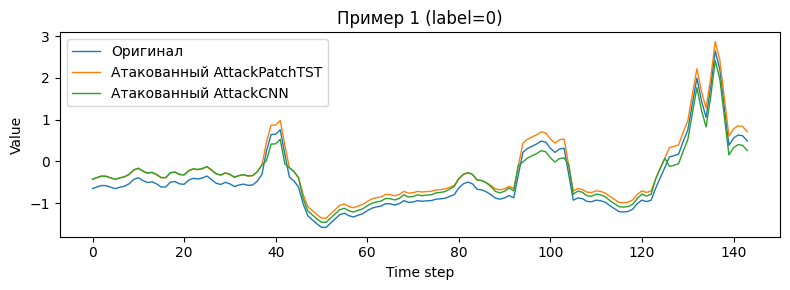

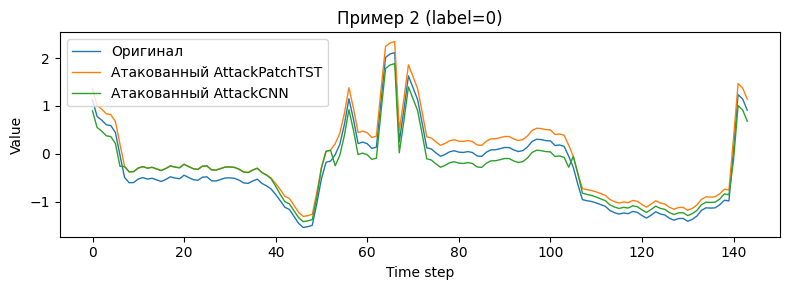

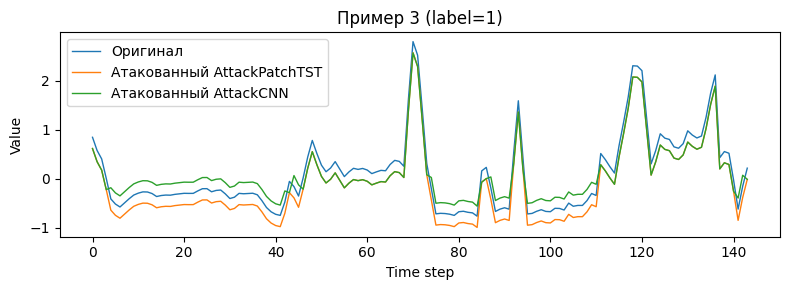

In [106]:
# import torch
import matplotlib.pyplot as plt
import random

# --- SETTINGS (adjust if you used other names) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPS = 0.23                      # то же eps, что и при обучении surrogate
N_EXAMPLES = 3                  # сколько примеров показать
SURR_MODELS = [surr_PatchTST, surrogate_cnn][:]
# random.seed(0)



# выбираем случайные batch-и, вытаскиваем по одному примеру
chosen = []
for xb, yb in test_dl:
    for i in range(xb.size(0)):
        chosen.append((xb[i], yb[i]))
    if len(chosen) >= 50:       # достаточно выборки для случайного выбора
        break

examples = random.sample(chosen, N_EXAMPLES)



for idx, (x_orig, y_lbl) in enumerate(examples, 1):
    x_orig = x_orig.to(device).unsqueeze(0)            # shape (1, T, F?) / (1,T)
    x_np      = x_orig.squeeze().cpu().numpy()
    x_adv_np_list = []
    for surr in SURR_MODELS:
        surr.eval()
        with torch.no_grad():
            delta = EPS * torch.tanh(surr(x_orig))
            x_adv = x_orig + delta
            x_adv_np_list.append(x_adv.squeeze().cpu().numpy())

    # отдельный plot для каждой пары
    plt.figure(figsize=(8, 3))
    plt.plot(x_np,     label='Оригинал', linewidth=1)
    for i, x_adv_np in enumerate(x_adv_np_list):
        plt.plot(x_adv_np, label=f'Атакованный {SURR_MODELS[i].__class__.__name__}', linewidth=1)
    plt.title(f'Пример {idx} (label={int(y_lbl)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
